In [ ]:
!pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=bc8cd60f0f4b9b5c2f7402bd2dad8898fcb20955c777d96c55ce20ff2e0e0c06
  Stored in directory: /root/.cache/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


- Bộ dữ liệu gồm:
  * Channel: Kênh phân phối của khách hàng (1 = Horeca - Hotel/Restaurant/Cafe, 2 = Retail - Bán lẻ)
  * Region: Khu vực địa lý của khách hàng (1 = Lisbon, 2 = Oporto, 3 = Other)
  * Fresh: Số tiền khách hàng đã chi cho các sản phẩm tươi sống (Fresh products)
  * Milk: Số tiền khách hàng đã chi cho sản phẩm sữa (Milk products)
  * Grocery: Số tiền khách hàng đã chi cho hàng tạp hóa (Grocery products)
  * Frozen: Số tiền khách hàng đã chi cho thực phẩm đông lạnh (Frozen products)
  * Detergents_Paper: Số tiền khách hàng đã chi cho các sản phẩm tẩy rửa và giấy (Detergents and paper products)
  * Delicassen: Số tiền khách hàng đã chi cho thực phẩm cao cấp (Delicatessen products)

## Khám phá dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = "/content/drive/MyDrive/data"
if not os.path.exists(path):
    os.makedirs(path)
    print("Thư mục 'data' đã được tạo.")
else:
    print("Thư mục 'data' đã tồn tại.")

Thư mục 'data' đã tồn tại.


In [ ]:
file_path = '/content/drive/MyDrive/data/Wholesale_customers_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [ ]:
df.isnull().sum()

,0
Channel,0
Region,0
Fresh,0
Milk,0
Grocery,0
Frozen,0
Detergents_Paper,0
Delicassen,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [ ]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## Data preprocessing

### Data reduction

In [ ]:
# Xóa 2 cột không cần thiết ko ảnh hưởng đến quá trình phân cụm
df = df.drop(columns=['Channel', 'Region'])

# Kiểm tra lại dataset
df.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

### Data Cleaning

#### Remove noise

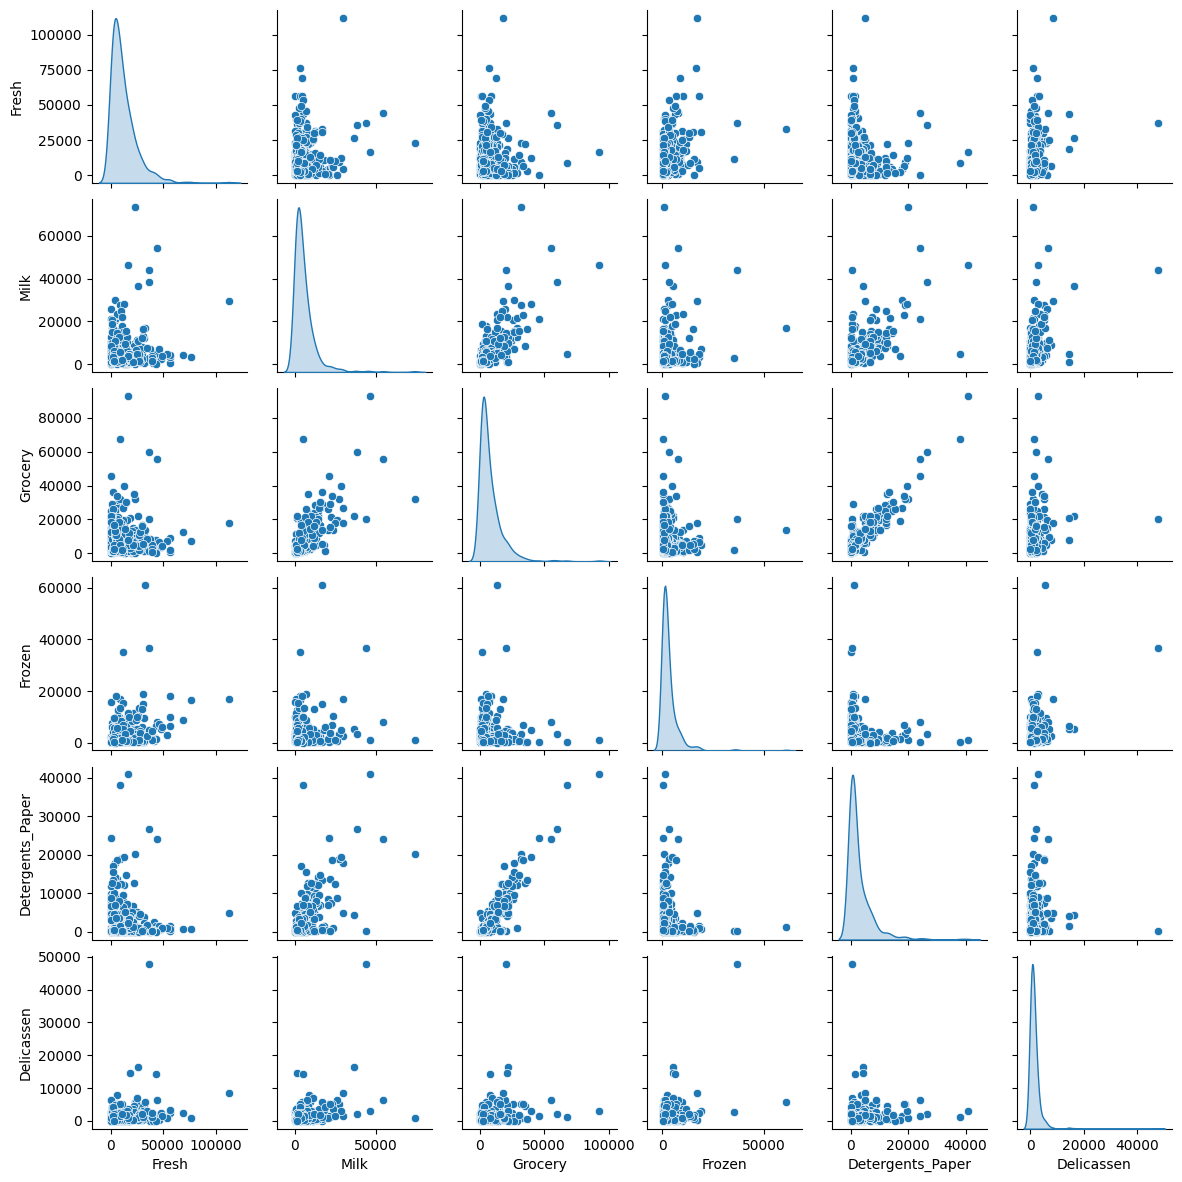

In [ ]:
# Biểu đồ phân bổ dữ liệu ban đầu
sns.pairplot(df, kind='scatter', diag_kind='kde', height=2, aspect=1)
plt.show()

In [ ]:
# Hàm phát hiện ngoại lai dựa trên IQR
def detect_outliers(df):
    outlier_dict = {}  # Dictionary lưu danh sách ngoại lai của từng cột

    for column in df.columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR

        # Lưu giá trị ngoại lai của từng cột
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column].values
        outlier_dict[column] = outliers

        print(f"📌 Column: {column}")
        print(f"🔹 Upper Bound: {upper_bound}, Lower Bound: {lower_bound}")
        print(f"⚠️ Số lượng ngoại lai: {len(outliers)}")
        print(f"🔸 Giá trị ngoại lai: {outliers[:10]} ...")  # Hiển thị tối đa 10 giá trị
        print("-" * 50)

    return outlier_dict

# Gọi hàm detect_outliers để kiểm tra ngoại lai trên dataset
outliers = detect_outliers(df)

📌 Column: Fresh
🔹 Upper Bound: 37642.75, Lower Bound: -17581.25
⚠️ Số lượng ngoại lai: 20
🔸 Giá trị ngoại lai: [ 43088  56159  44466  40721  43265  56082  76237  42312  45640 112151] ...
--------------------------------------------------
📌 Column: Milk
🔹 Upper Bound: 15676.125, Lower Bound: -6952.875
⚠️ Số lượng ngoại lai: 28
🔸 Giá trị ngoại lai: [36423 20484 15729 22044 54259 21412 29892 38369 20959 46197] ...
--------------------------------------------------
📌 Column: Grocery
🔹 Upper Bound: 23409.875, Lower Bound: -10601.125
⚠️ Số lượng ngoại lai: 24
🔸 Giá trị ngoại lai: [25957 23998 55571 28921 26866 59598 45828 28540 92780 32114] ...
--------------------------------------------------
📌 Column: Frozen
🔹 Upper Bound: 7772.25, Lower Bound: -3475.75
⚠️ Số lượng ngoại lai: 43
🔸 Giá trị ngoại lai: [ 9408 10002  9510  7782 10643  8872  8132  9735  8693 35009] ...
--------------------------------------------------
📌 Column: Detergents_Paper
🔹 Upper Bound: 9419.875, Lower Bound: -5241.125


In [ ]:
# Hàm loại bỏ ngoại lai theo IQR
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)  # Phân vị thứ 25%
    Q3 = data.quantile(0.75)  # Phân vị thứ 75%
    IQR = Q3 - Q1             # Interquartile range

    # Xác định ngưỡng để loại bỏ ngoại lai
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Giữ lại các điểm dữ liệu nằm trong khoảng hợp lệ
    return data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

# Áp dụng loại bỏ ngoại lai
df_no_outliers = remove_outliers_iqr(df)

# Kiểm tra số lượng dòng trước và sau khi loại bỏ ngoại lai
print(f"Số dòng trước khi loại bỏ ngoại lai: {df.shape[0]}")
print(f"Số dòng sau khi loại bỏ ngoại lai: {df_no_outliers.shape[0]}")


Số dòng trước khi loại bỏ ngoại lai: 440
Số dòng sau khi loại bỏ ngoại lai: 332


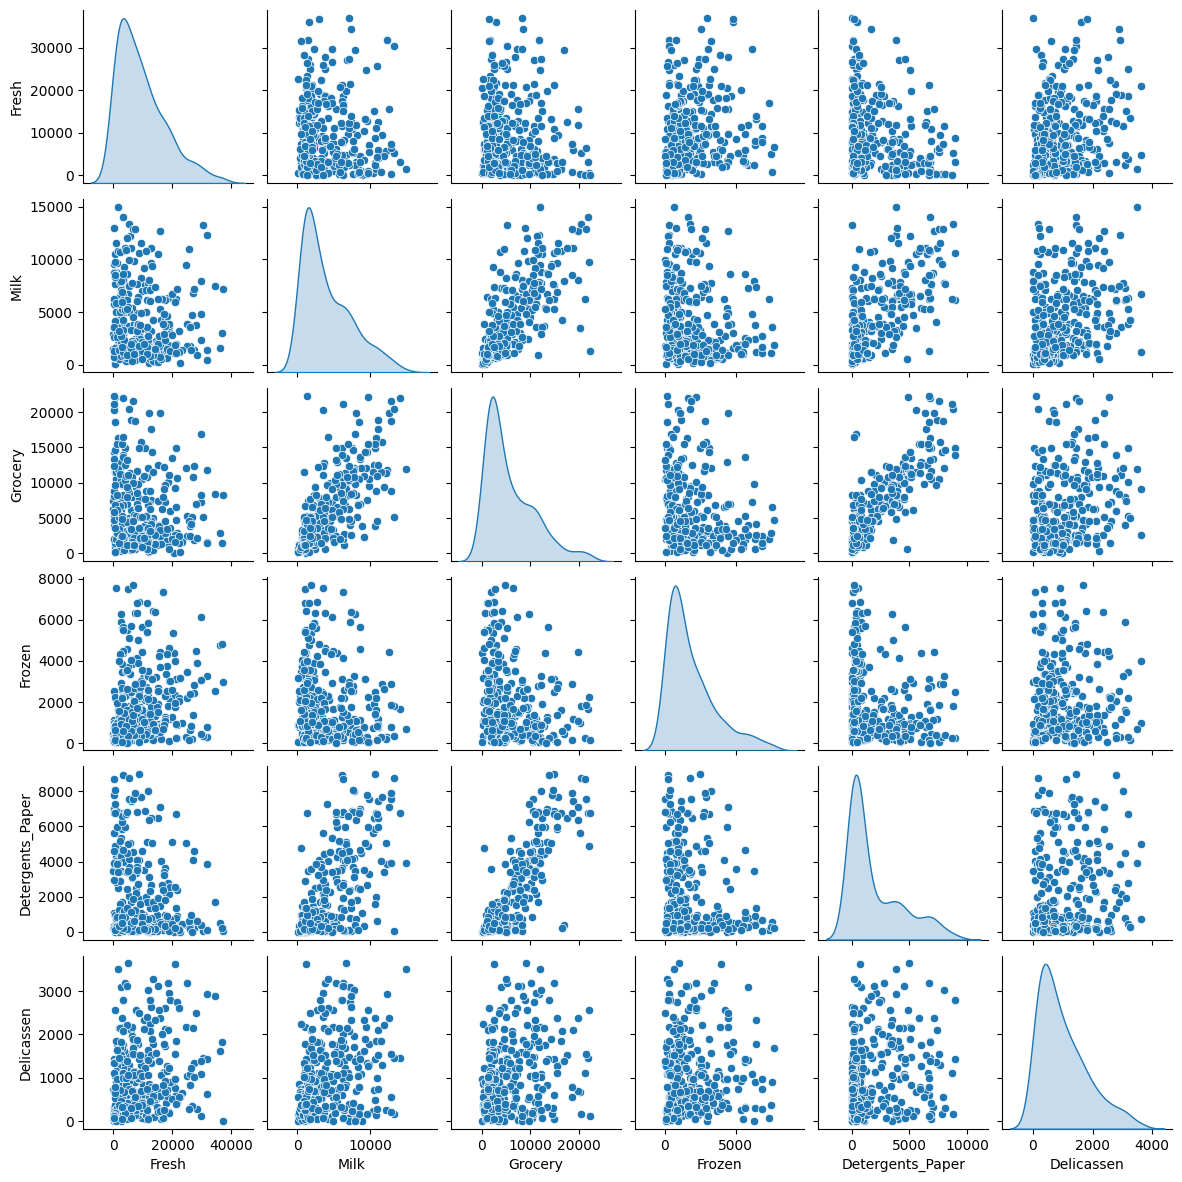

In [ ]:
# Biểu đồ phân bổ dữ liệu khi loại bỏ outlier
sns.pairplot(df_no_outliers, kind='scatter', diag_kind='kde', height=2, aspect=1)
plt.show()

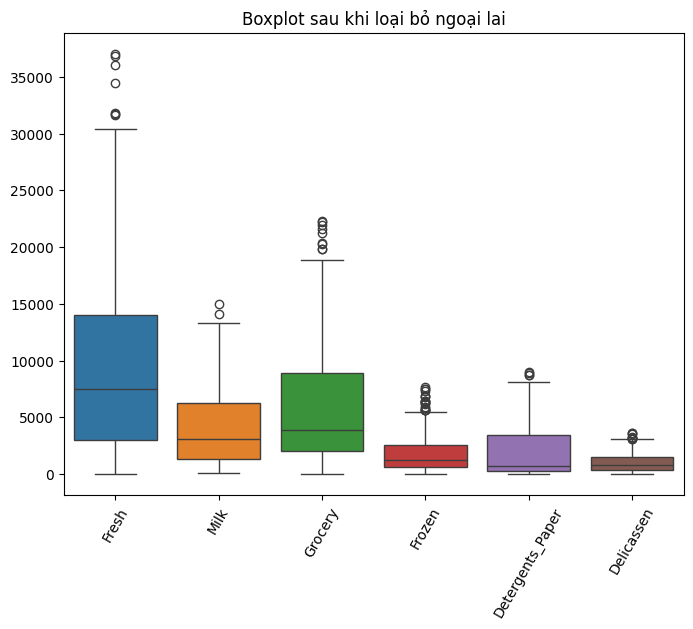

In [ ]:
# Vẽ lại boxplot để kiểm tra ngoại lai đã bị loại bỏ
plt.figure(figsize=(8,6))
sns.boxplot(data=df_no_outliers)
plt.xticks(rotation=60)
plt.title("Boxplot sau khi loại bỏ ngoại lai")
plt.show()

#### Correct data inconsistencies

In [ ]:
df = df_no_outliers.copy()

In [ ]:
# Kiểm tra số lượng giá trị bằng 0 trong từng cột
zero_counts = (df == 0).sum()
print("Số lượng giá trị bằng 0 trong mỗi cột:\n", zero_counts)

Số lượng giá trị bằng 0 trong mỗi cột:
 Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


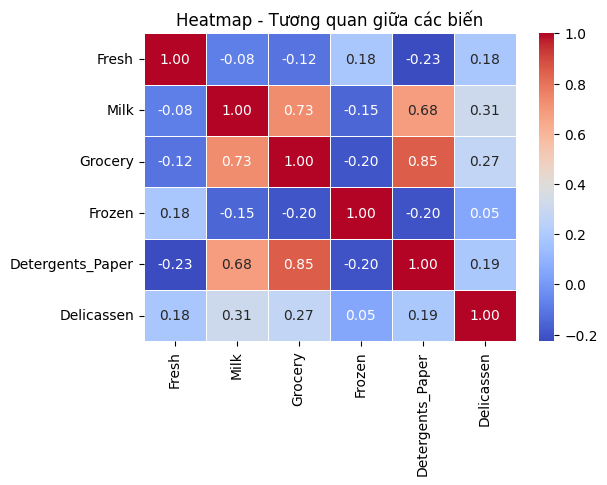

In [ ]:
# Vẽ heatmap để xem mối tương quan giữa các biến
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap - Tương quan giữa các biến")
plt.show()

### Data transformation

In [ ]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_no_outliers)

# Chuyển lại thành DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df_no_outliers.columns)

# Kiểm tra dữ liệu sau chuẩn hóa
df_scaled.describe() # Dữ liệu nằm trong khoảng (-3, 3)

# df_scaled.to_csv('/content/drive/MyDrive/data/Wholesale_customers_data_clean.csv', index=False)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,3.320000e+02,3.320000e+02,3.320000e+02,3.320000e+02,3.320000e+02,3.320000e+02
mean,-1.177104e-16,1.284113e-16,5.350472e-17,-1.605142e-17,2.140189e-17,-6.955614e-17
std,1.001509e+00,1.001509e+00,1.001509e+00,1.001509e+00,1.001509e+00,1.001509e+00
min,-1.171159e+00,-1.206045e+00,-1.167208e+00,-1.077834e+00,-8.344848e-01,-1.231424e+00
25%,-8.046657e-01,-8.196810e-01,-7.680096e-01,-7.512086e-01,-7.368924e-01,-7.967938e-01
50%,-2.532536e-01,-3.031893e-01,-4.054816e-01,-3.474711e-01,-5.305085e-01,-2.947372e-01
75%,5.447986e-01,6.391958e-01,6.067743e-01,4.248196e-01,6.409204e-01,5.338233e-01
max,3.373029e+00,3.238851e+00,3.258853e+00,3.412828e+00,2.990711e+00,3.183516e+00


In [ ]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fresh             332 non-null    float64
 1   Milk              332 non-null    float64
 2   Grocery           332 non-null    float64
 3   Frozen            332 non-null    float64
 4   Detergents_Paper  332 non-null    float64
 5   Delicassen        332 non-null    float64
dtypes: float64(6)
memory usage: 15.7 KB


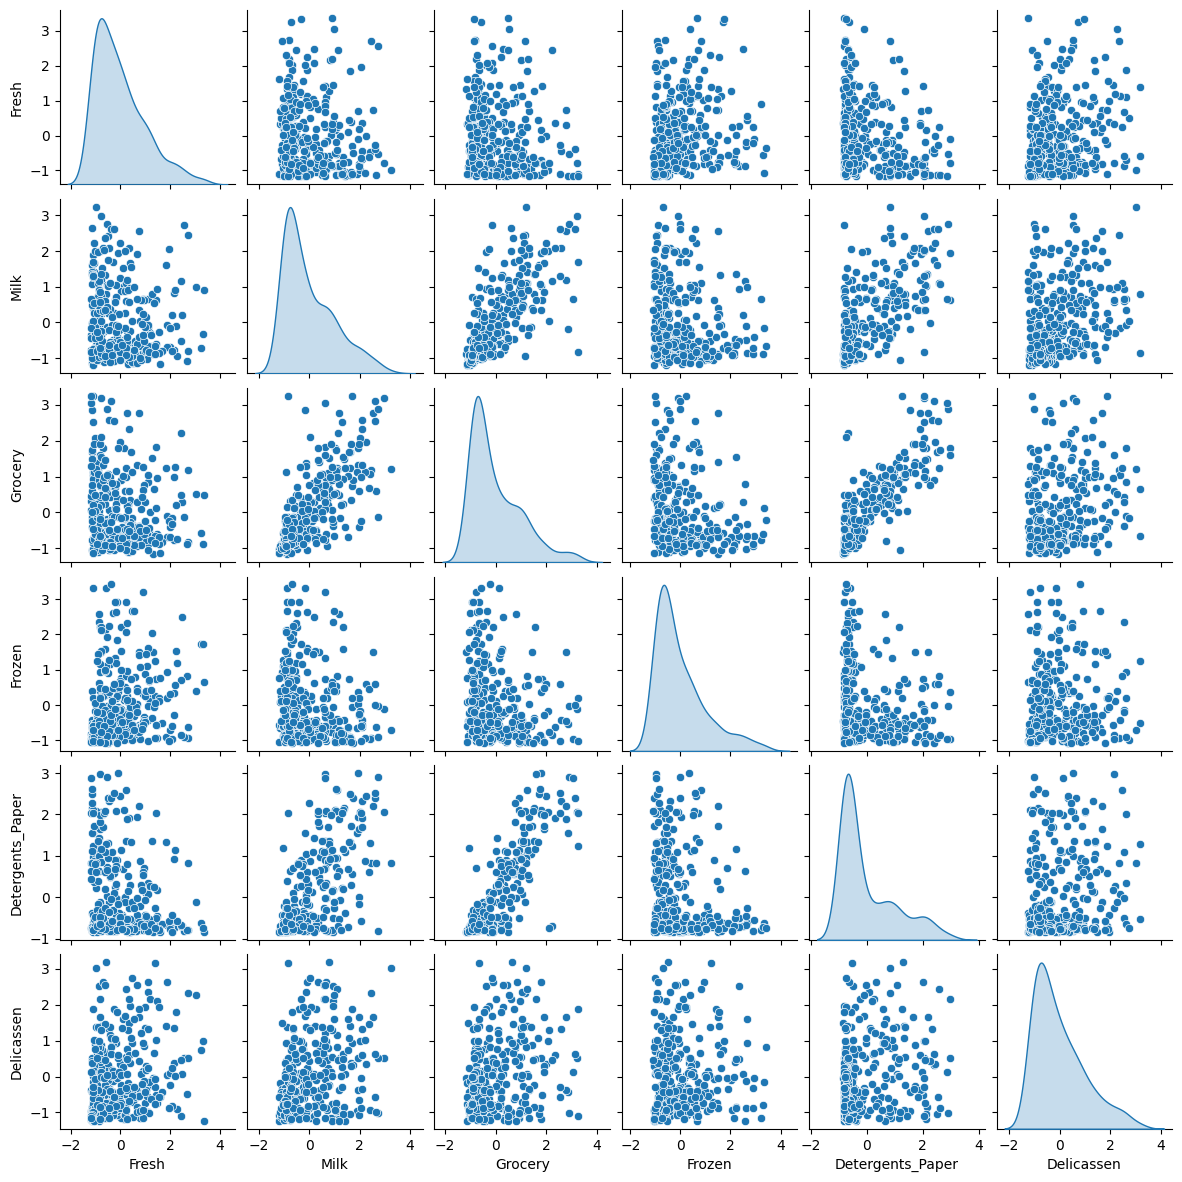

In [ ]:
# Vẽ lại biểu đồ phân bố dữ liệu sau chuẩn hóa
sns.pairplot(df_scaled, kind='scatter', diag_kind='kde', height=2, aspect=1)
plt.show()

## Thuật toán 1: CLARANS (Clustering Large Applications based upon Randomized Search)

[Nguồn tham khảo](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4)

### Sử dụng Thư viện

In [ ]:
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import timedcall
from pyclustering.cluster import cluster_visualizer_multidim
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Chuyển dữ liệu thành danh sách
file_path = '/content/drive/MyDrive/data/Wholesale_customers_data_clean.csv'
df_scaled = pd.read_csv(file_path)
data = df_scaled.values.tolist()

# Xác định số cụm k
k = 3
num_local = 5
num_neighbors = 2

# Khởi chạy CLARANS
clarans_instance = clarans(data, k, num_local, num_neighbors)
(ticks, result) = timedcall(clarans_instance.process)
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

print(f"Execution time: {ticks:.4f} s")
# print("Clusters:", clusters)
print("Clusters:")
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i + 1}: {cluster}")  # Hiển thị từng cụm riêng biệt
print("Medoids:", medoids)

Execution time: 5.8305 s
Clusters:
  Cluster 1: [4, 6, 16, 19, 23, 26, 27, 35, 38, 42, 46, 54, 59, 63, 64, 65, 66, 82, 91, 93, 99, 101, 111, 114, 125, 129, 130, 133, 137, 138, 145, 151, 152, 154, 155, 171, 175, 177, 183, 190, 194, 196, 206, 207, 209, 210, 214, 218, 220, 223, 225, 227, 230, 240, 242, 248, 256, 258, 261, 262, 263, 266, 268, 269, 272, 273, 274, 284, 285, 290, 295, 296, 309, 310, 311, 317, 324, 325, 328, 331]
  Cluster 2: [0, 1, 3, 5, 7, 8, 10, 11, 12, 14, 15, 17, 22, 28, 29, 30, 31, 32, 33, 36, 39, 41, 43, 44, 47, 48, 50, 56, 57, 60, 62, 68, 69, 70, 73, 74, 75, 77, 88, 90, 98, 100, 102, 103, 113, 115, 117, 118, 119, 122, 123, 124, 128, 131, 132, 134, 135, 136, 140, 141, 142, 146, 148, 158, 159, 160, 164, 169, 173, 184, 185, 192, 200, 201, 203, 213, 215, 221, 226, 228, 229, 231, 232, 238, 252, 254, 255, 259, 260, 264, 265, 275, 280, 283, 287, 299, 305, 308, 313, 314, 315, 316, 318, 319, 323, 326]
  Cluster 3: [2, 9, 13, 18, 20, 21, 24, 25, 34, 37, 40, 45, 49, 51, 52, 53, 5

In [ ]:
# Chuyển kết quả thành nhãn cụm
labels = np.zeros(len(data))
for cluster_idx, cluster in enumerate(clusters):
    for index in cluster:
        labels[index] = cluster_idx

# Tính Silhouette Score
sil_score = silhouette_score(data, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.1607


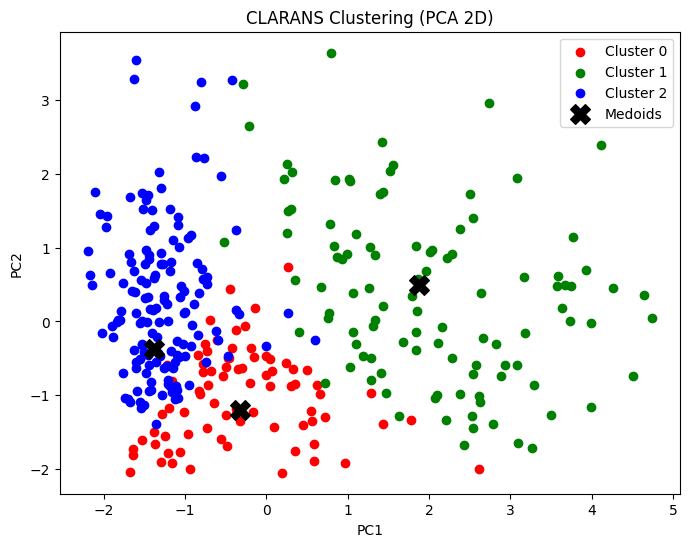

In [ ]:
# === 2D PCA Visualization ===
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
medoids_2d = pca.transform([data[i] for i in medoids])

plt.figure(figsize=(8,6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

# Vẽ từng cụm
for i, cluster in enumerate(clusters):
    cluster_points = np.array([data_2d[idx] for idx in cluster])
    plt.scatter(cluster_points[:,0], cluster_points[:,1], c=colors[i % len(colors)], label=f"Cluster {i}")

# Vẽ Medoids
plt.scatter(medoids_2d[:,0], medoids_2d[:,1], c='black', marker='X', s=200, label='Medoids')

plt.title("CLARANS Clustering (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

### Không sử dụng thư viện

In [ ]:
import random
import math

class CLARANS:
    def __init__(self, data, k, max_neighbors, num_local):
        self.data = data  # Bộ dữ liệu
        self.k = k   # Số cụm
        self.max_neighbors = max_neighbors   # Số lượng hàng xóm
        self.num_local = num_local   # Số lần lặp
        self.best_medoids = []   # Các medoids tối ưu (khởi tạo là danh sách rỗng)
        self.min_cost = float('inf')  # Chi phí tối ưu

    def calculate_distance(self, point1, point2):
        """Tính khoảng cách Euclidean giữa hai điểm"""
        return math.sqrt(sum((a - b) ** 2 for a, b in zip(point1, point2)))

    def calculate_total_cost(self, medoids):
        """Tính tổng chi phí cho một tập medoids"""
        total_cost = 0
        for point in self.data:
            min_dist = float('inf')
            for medoid in medoids:
                dist = self.calculate_distance(point, self.data[medoid])
                min_dist = min(min_dist, dist)
            total_cost += min_dist
        return total_cost

    def find_clusters(self, medoids):
        """Phân các điểm dữ liệu vào các cụm dựa trên medoids"""
        clusters = [[] for _ in range(self.k)]

        # Gán mỗi điểm vào cụm gần nhất
        for idx, point in enumerate(self.data):
            min_dist = float('inf')
            cluster_idx = 0

            # Tìm medoid gần nhất
            for i, medoid in enumerate(medoids):
                dist = self.calculate_distance(point, self.data[medoid])
                if dist < min_dist:
                    min_dist = dist
                    cluster_idx = i

            # Thêm điểm vào cụm tương ứng
            clusters[cluster_idx].append(idx)

        return clusters

    def run(self):
        """Thực thi thuật toán CLARANS"""
        for i in range(self.num_local):
            # Chọn ngẫu nhiên k medoids ban đầu
            current_medoids = random.sample(range(len(self.data)), self.k)
            j = 0

            while j < self.max_neighbors:
                # Tính chi phí hiện tại
                current_cost = self.calculate_total_cost(current_medoids)

                # Chọn ngẫu nhiên một medoid để thay thế
                medoid_to_swap = random.choice(current_medoids)

                # Chọn một điểm ngẫu nhiên không phải medoid để thay thế
                while True:
                    new_medoid = random.randint(0, len(self.data) - 1)
                    if new_medoid not in current_medoids:
                        break

                # Tạo tập medoid mới
                new_medoids = current_medoids.copy()
                new_medoids[new_medoids.index(medoid_to_swap)] = new_medoid

                # Tính chi phí mới
                new_cost = self.calculate_total_cost(new_medoids)

                # Nếu tìm được giải pháp tốt hơn
                # if new_cost < current_cost:
                #     current_medoids = new_medoids
                #     j = 0  # Reset counter
                # else:
                j += 1

            # Cập nhật giải pháp tốt nhất nếu cần
            final_cost = self.calculate_total_cost(current_medoids)
            if final_cost < self.min_cost:
                self.min_cost = final_cost
                self.best_medoids = current_medoids.copy()

        # Phân cụm dựa trên medoids tốt nhất
        clusters = self.find_clusters(self.best_medoids)
        return clusters, self.best_medoids

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import silhouette_score

file_path = '/content/drive/MyDrive/data/Wholesale_customers_data_clean.csv'
df_scaled = pd.read_csv(file_path)
df_scaled = df_scaled.reset_index(drop=True)  # Đảm bảo index liên tục
data = df_scaled.values.tolist()  # Chuyển thành danh sách

# Danh sách giá trị cần thử cho từng tham số
k_values = range(2, 6)   # Số cụm
max_neighbors_values = range(5, 25, 5)  # Số hàng xóm
num_local_values = range(1, 5)  # Số lần lặp

best_score = -1
best_params = None

# Thử nghiệm tất cả các bộ tham số
for k, max_neighbors, num_local in itertools.product(k_values, max_neighbors_values, num_local_values):
    clarans = CLARANS(data, k, max_neighbors, num_local)
    clusters, medoids = clarans.run()

    # Chuyển kết quả về danh sách nhãn cụm
    labels = np.zeros(len(data))
    for cluster_idx, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = cluster_idx

    # Tính Silhouette Score
    if len(set(labels)) > 1:  # Tránh lỗi nếu chỉ có 1 cụm
        score = silhouette_score(data, labels)
        if score > best_score:
            best_score = score
            best_params = (k, max_neighbors, num_local)
            print(f"New best params: k={k}, max_neighbors={max_neighbors}, num_local={num_local}, score={score:.4f}")

# Kết quả cuối cùng
print("\n🏆 Best Parameters:")
print(f"  k={best_params[0]}, max_neighbors={best_params[1]}, num_local={best_params[2]}")
print(f"  Best Silhouette Score: {best_score:.4f}")


New best params: k=2, max_neighbors=5, num_local=1, score=0.1859
New best params: k=2, max_neighbors=5, num_local=2, score=0.1936
New best params: k=2, max_neighbors=10, num_local=4, score=0.2983
New best params: k=2, max_neighbors=15, num_local=2, score=0.3118
New best params: k=2, max_neighbors=15, num_local=3, score=0.3378
New best params: k=2, max_neighbors=20, num_local=2, score=0.3417
New best params: k=2, max_neighbors=20, num_local=3, score=0.3553

🏆 Best Parameters:
  k=2, max_neighbors=20, num_local=3
  Best Silhouette Score: 0.3553


In [ ]:
# Dùng tham số tối ưu tìm được
k, max_neighbors, num_local = best_params

clarans = CLARANS(data, k, max_neighbors, num_local)
clusters, medoids = clarans.run()

# Hiển thị kết quả
print("Clusters:")
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i}: {cluster}")
print("Medoids:", medoids)

Clusters:
  Cluster 0: [4, 6, 9, 13, 16, 18, 19, 20, 21, 23, 24, 25, 26, 35, 37, 40, 42, 45, 46, 49, 51, 53, 55, 58, 59, 61, 63, 64, 65, 66, 67, 71, 72, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 99, 101, 104, 105, 106, 107, 108, 109, 110, 112, 114, 116, 120, 121, 125, 126, 127, 133, 137, 138, 139, 143, 144, 145, 147, 149, 150, 151, 152, 153, 156, 157, 161, 162, 163, 165, 167, 168, 170, 171, 174, 175, 177, 178, 179, 180, 181, 182, 186, 187, 188, 189, 190, 193, 194, 196, 197, 198, 204, 205, 208, 209, 210, 214, 216, 217, 218, 219, 222, 223, 224, 225, 227, 233, 234, 235, 236, 237, 239, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 257, 258, 261, 262, 263, 266, 267, 269, 270, 271, 272, 273, 274, 276, 277, 278, 279, 281, 282, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 296, 297, 298, 300, 301, 302, 303, 304, 305, 306, 307, 309, 312, 317, 320, 321, 322, 324, 327, 328, 329, 330, 331]
  Cluster 1: [0, 1, 2, 3, 5, 7, 8, 10, 11, 12, 14, 15, 17, 22,

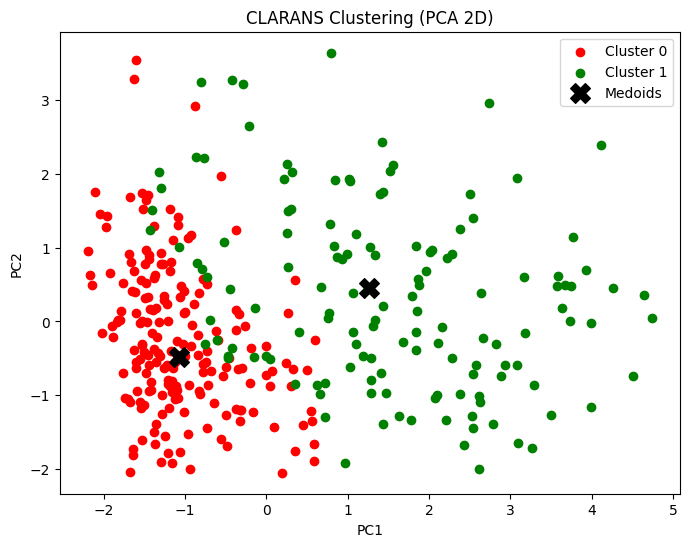

In [ ]:
# === 2D PCA Visualization ===
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
medoids_2d = pca.transform([data[i] for i in medoids])

plt.figure(figsize=(8,6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

# Vẽ từng cụm
for i, cluster in enumerate(clusters):
    cluster_points = np.array([data_2d[idx] for idx in cluster])
    plt.scatter(cluster_points[:,0], cluster_points[:,1], c=colors[i % len(colors)], label=f"Cluster {i}")

# Vẽ Medoids
plt.scatter(medoids_2d[:,0], medoids_2d[:,1], c='black', marker='X', s=200, label='Medoids')

plt.title("CLARANS Clustering (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

### Phân tích các đặc trưng cụm

In [ ]:
# Tính trung bình và phương sai cho từng cụm
for i, cluster in enumerate(clusters):
    cluster_data = np.array([data[idx] for idx in cluster])
    cluster_mean = cluster_data.mean(axis=0)
    cluster_std = cluster_data.std(axis=0)
    print(f"Cluster {i}:")
    print(f"  Mean: {cluster_mean}")
    print(f"  Std Dev: {cluster_std}")


Cluster 0:
  Mean: [ 0.1175097  -0.57791489 -0.57590018  0.02398095 -0.55969107 -0.47899464]
  Std Dev: [0.99785664 0.51467284 0.44788666 0.96934078 0.37780548 0.55060498]
Cluster 1:
  Mean: [-0.16519479  0.81243108  0.8095988  -0.03371235  0.78681208  0.67336927]
  Std Dev: [0.97944805 0.95071439 1.00104567 1.04064156 1.07037046 1.09710574]


* **Cluster 0** có đặc trưng là mức tiêu thụ `Fresh` và `Frozen` cao, nhưng các thuộc tính khác như `Grocery` và `Milk` có giá trị thấp hơn. Các điểm trong cụm này có sự phân tán khá lớn   --> Cụm này có thể gồm các khách hàng tiêu thụ nhiều sản phẩm tươi sống và đông lạnh, nhưng ít sử dụng các sản phẩm khác như sữa và đồ khô.
* **Cluster 1** có mức tiêu thụ `Milk` và `Grocery` cao hơn, trong khi `Fresh` lại thấp. Tuy nhiên, độ lệch chuẩn của các thuộc tính này lớn, cho thấy sự biến động đáng kể trong cụm.   --> Điều này có thể chỉ ra rằng nhóm khách hàng này ưu tiên các sản phẩm khô hoặc chế biến sẵn thay vì các sản phẩm tươi sống hoặc đông lạnh.

In [ ]:
from sklearn.metrics import davies_bouldin_score

# Tính Davies-Bouldin Index cho các cụm
davies_bouldin = davies_bouldin_score(data, labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")

Davies-Bouldin Index: 1.5638275600662888


* **Davies-Bouldin Index (DBI)** là 1.565, cho thấy các cụm chưa phân tách rõ ràng và có sự chồng lấn nhẹ giữa chúng. --> Cần cải thiện

## Thuật Toán 2: BIRCH (Balanced Iterative Reducing Clustering and using Hierarchies)

[Nguồn tham khảo](https://medium.com/@vipulddalal/birch-algorithm-with-working-example-a7b8fe047bd4)

### Sử dụng thư viện

In [ ]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

file_path = '/content/drive/MyDrive/data/Wholesale_customers_data_clean.csv'
df_scaled = pd.read_csv(file_path)

# Áp dụng thuật toán BIRCH
birch_model = Birch(n_clusters=3)  # Thay đổi số cụm n_clusters nếu cần
birch_model.fit(df_scaled)

# Lấy nhãn cụm
labels = birch_model.labels_

# Chuyển DataFrame thành NumPy array để dễ xử lý
df_array = df_scaled.to_numpy()

# In ra danh sách các cụm, số lượng phần tử và tâm mỗi cụm
clusters = {}
cluster_centers = {}

for i, cluster_id in enumerate(labels):
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(df_array[i])  # Lưu điểm vào cụm tương ứng

print("\nThông tin các cụm:")
for cluster_id, points in clusters.items():
    points_array = np.array(points)
    cluster_center = points_array.mean(axis=0)  # Tính tâm cụm
    cluster_centers[cluster_id] = cluster_center
    print(f"Cụm {cluster_id}:")
    print(f" - Số lượng phần tử: {len(points)}")
    print(f" - Tâm cụm: {cluster_center}")
    print()


Thông tin các cụm:
Cụm 0:
 - Số lượng phần tử: 97
 - Tâm cụm: [-0.48699357  0.97754024  1.13893294 -0.36221883  1.26318407  0.04176452]

Cụm 2:
 - Số lượng phần tử: 41
 - Tâm cụm: [ 0.8609675   0.61385042  0.35368486  0.00542098 -0.03249711  1.60174827]

Cụm 1:
 - Số lượng phần tử: 194
 - Tâm cụm: [ 0.06153974 -0.61850139 -0.6442143   0.17996374 -0.62472409 -0.35939607]



In [ ]:
# Tính chỉ số Silhouette score
sil_score = silhouette_score(df_scaled, labels)
print(f'Silhouette Score: {sil_score:.4f}')

Silhouette Score: 0.2960


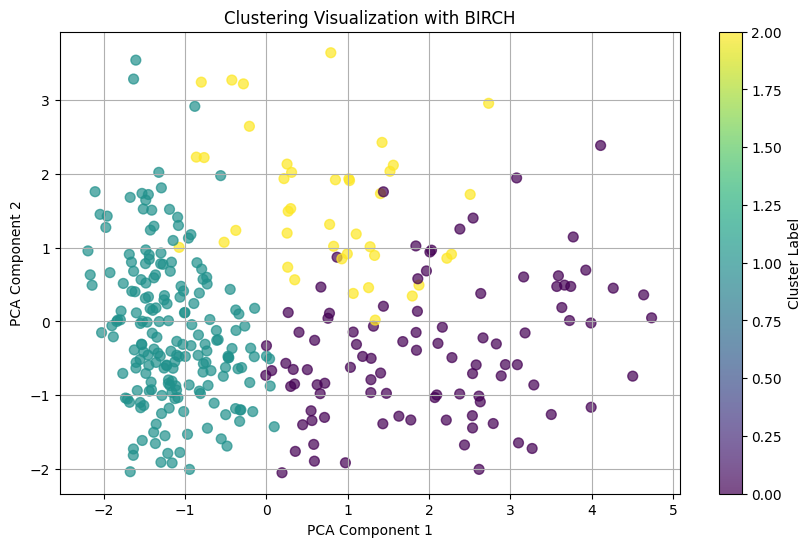

In [ ]:
# Biểu đồ minh họa các cụm bằng cách giảm chiều dữ liệu với PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.title('Clustering Visualization with BIRCH')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()

plt.show()

### Không sử dụng thư viện

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter

class CFNode:
    def __init__(self, N=0, mean=None, ssd=0, children=None, n_features=None):
        self.N = N  # Số lượng điểm dữ liệu
        self.mean = mean if mean is not None else np.zeros(n_features)  # Trung bình, tự động điều chỉnh theo số chiều
        self.ssd = ssd  # Tổng bình phương sự sai lệch
        self.children = children if children is not None else []  # Các node con

class CFTree:
    def __init__(self, threshold, branching_factor, n_features):
        self.threshold = threshold  # Ngưỡng để chia hoặc hợp nhất các cụm
        self.branching_factor = branching_factor  # Số lượng node con tối đa trong mỗi node
        self.root = CFNode(n_features=n_features)  # Khởi tạo cây với một node gốc

    def insert(self, point):
        node = self.root
        # Tìm node phù hợp để thêm điểm
        while node.children:
            closest_child = None
            min_dist = float('inf')
            for child in node.children:
                dist = np.linalg.norm(point - child.mean)
                if dist < min_dist:
                    closest_child = child
                    min_dist = dist
            node = closest_child

        # Cập nhật thông tin trong node
        node.N += 1
        node.mean = (node.mean * (node.N - 1) + point) / node.N
        node.ssd += np.sum((point - node.mean) ** 2)

        # Nếu node quá tải, cần phải chia hoặc tái cấu trúc
        if node.N > self.threshold:
            self.split_node(node)

    def split_node(self, node):
        # Phân chia node nếu vượt quá ngưỡng
        if len(node.children) >= self.branching_factor:
            # Đảm bảo mỗi node mới có số chiều phù hợp
            new_node = CFNode(n_features=node.mean.shape[0])

            # Tìm các điểm con cần phải di chuyển sang node mới (dựa trên khoảng cách)
            min_dist = float('inf')
            for child in node.children:
                dist = np.linalg.norm(node.mean - child.mean)
                if dist < min_dist:
                    new_node.children.append(child)
                    node.children.remove(child)
            node.children.append(new_node)

    def rebuild_tree(self, node):
        # Tái cấu trúc cây khi số phần tử trong node quá tải
        new_node = CFNode(n_features=node.mean.shape[0])
        node.children.clear()  # Xóa hết các node con cũ
        node.children.append(new_node)

    def get_clusters(self):
        # Lấy thông tin cụm từ cây
        return [child.mean for child in self.root.children]

def birch(data, threshold, branching_factor, n_clusters=None):
    # Bước 1: Xây dựng cây CF
    n_features = data.shape[1]  # Lấy số chiều từ dữ liệu
    tree = CFTree(threshold, branching_factor, n_features=n_features)
    for point in data:
        tree.insert(point)

    clusters = tree.get_clusters()

    # Bước 2: Áp dụng K-means cho các cụm cuối cùng
    if n_clusters is None:
        n_clusters = len(clusters)  # Nếu không chỉ định số cụm, lấy số cụm từ cây
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)

    return kmeans.labels_, kmeans.cluster_centers_

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score
import pandas as pd
import warnings

# Tắt cảnh báo
warnings.filterwarnings("ignore", category=UserWarning)

# Đọc dữ liệu
file_path = '/content/drive/MyDrive/data/Wholesale_customers_data_clean.csv'
df_scaled = pd.read_csv(file_path)
data = df_scaled.values

# Các giá trị tham số để thử nghiệm
thresholds = [0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.8, 2.0]
branching_factors = [5, 10, 15, 20]
n_clusters_list = [2, 3, 4]

# Biến lưu kết quả tốt nhất
best_score = -1
best_params = {}

# Tìm kiếm tham số tối ưu
for threshold in thresholds:
    for branching_factor in branching_factors:
        for n_clusters in n_clusters_list:
            try:
                # Áp dụng thuật toán BIRCH
                labels, centers = birch(
                    data=data,
                    threshold=threshold,
                    branching_factor=branching_factor,
                    n_clusters=n_clusters
                )

                # Kiểm tra số cụm thực tế
                n_actual_clusters = len(np.unique(labels))
                if n_actual_clusters < n_clusters:
                    continue

                # Tính Silhouette Score
                score = silhouette_score(data, labels)

                # Cập nhật kết quả tốt nhất
                if score > best_score:
                    best_score = score
                    best_params = {
                        'threshold': threshold,
                        'branching_factor': branching_factor,
                        'n_clusters': n_clusters
                    }
            except Exception as e:
                # Bỏ qua lỗi nếu xảy ra
                print(f"Lỗi với threshold={threshold}, branching_factor={branching_factor}, n_clusters={n_clusters}: {e}")
                continue

# In kết quả tốt nhất
print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)

Best Silhouette Score: 0.35621155409743677
Best Parameters: {'threshold': 0.1, 'branching_factor': 5, 'n_clusters': 2}


In [ ]:
# Sử dụng tham số tốt nhất để chạy lại thuật toán BIRCH
threshold = best_params['threshold']
branching_factor = best_params['branching_factor']
n_clusters = best_params['n_clusters']

labels, centers = birch(data=data, threshold=threshold, branching_factor=branching_factor, n_clusters=n_clusters)

# Tính số lượng phần tử trong mỗi cụm
cluster_counts = Counter(labels)

# In ra thông tin cho mỗi cụm
for cluster_id in range(len(set(labels))):
    points_in_cluster = data[labels == cluster_id]
    cluster_center = points_in_cluster.mean(axis=0)  # Tính tâm cụm
    print(f"Cụm {cluster_id}:")
    print(f" - Số lượng phần tử: {len(points_in_cluster)}")
    print(f" - Tâm cụm: {cluster_center}")
    print()

Cụm 0:
 - Số lượng phần tử: 102
 - Tâm cụm: [-0.19707206  1.15035238  1.2122015  -0.306607    1.21823292  0.51866086]

Cụm 1:
 - Số lượng phần tử: 230
 - Tâm cụm: [ 0.08739717 -0.51015627 -0.53758501  0.13597354 -0.54025982 -0.23001482]



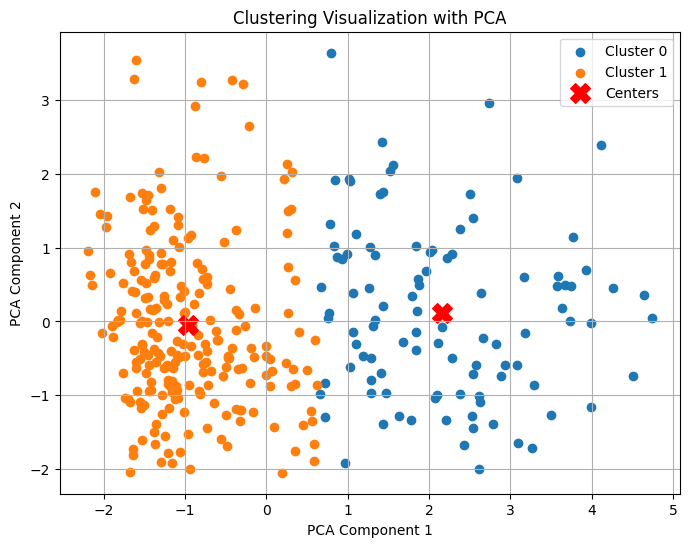

In [ ]:
# Giảm số chiều dữ liệu xuống 2 chiều bằng PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

# Vẽ biểu đồ phân cụm
plt.figure(figsize=(8, 6))
for cluster_id in np.unique(labels):
    cluster_points = data_2d[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')

# Vẽ các tâm cụm
centers_2d = pca.transform(centers)  # Biến đổi các tâm cụm sang không gian 2D
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='X', s=200, label='Centers')


# Thêm thông tin biểu đồ
plt.title('Clustering Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

### Phân tích các đặc trưng cụm

In [ ]:
# Thêm labels vào DataFrame
df_with_labels = df_scaled.copy()
df_with_labels['Cluster'] = labels

# Tính thống kê theo từng cụm
cluster_stats = df_with_labels.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])

# In thông tin cho mỗi cụm
for cluster_id in sorted(df_with_labels['Cluster'].unique()):
    points_in_cluster = df_with_labels[df_with_labels['Cluster'] == cluster_id].drop(columns='Cluster')
    print(f"Cụm {cluster_id}:")
    print(f" - Số lượng phần tử: {len(points_in_cluster)}")
    print(f" - Tâm cụm (mean):\n{points_in_cluster.mean()}")
    print(f" - Độ lệch chuẩn (std):\n{points_in_cluster.std()}")
    print(f" - Giá trị nhỏ nhất (min):\n{points_in_cluster.min()}")
    print(f" - Giá trị lớn nhất (max):\n{points_in_cluster.max()}")
    print("\n" + "-"*50 + "\n")


Cụm 0:
 - Số lượng phần tử: 102
 - Tâm cụm (mean):
Fresh              -0.197072
Milk                1.150352
Grocery             1.212201
Frozen             -0.306607
Detergents_Paper    1.218233
Delicassen          0.518661
dtype: float64
 - Độ lệch chuẩn (std):
Fresh               0.995862
Milk                0.813863
Grocery             0.837489
Frozen              0.740338
Detergents_Paper    0.886209
Delicassen          1.113644
dtype: float64
 - Giá trị nhỏ nhất (min):
Fresh              -1.166987
Milk               -0.842759
Grocery            -0.406972
Frozen             -1.077834
Detergents_Paper   -0.814006
Delicassen         -1.231424
dtype: float64
 - Giá trị lớn nhất (max):
Fresh               3.056201
Milk                3.238851
Grocery             3.258853
Frozen              2.583657
Detergents_Paper    2.990711
Delicassen          3.183516
dtype: float64

--------------------------------------------------

Cụm 1:
 - Số lượng phần tử: 230
 - Tâm cụm (mean):
Fresh      

***`Phân tích`***

**Cụm 0**
*   Đặc điểm chung:
  *   Chi tiêu thấp hơn trung bình cho hầu hết các loại mặt hàng, đặc biệt là:
        *   `Milk`: -0.51

        *   `Grocery`: -0.55

        *   `Detergents_Paper`: -0.54
  *   Chỉ số `Frozen` và `Fresh` trung bình (~0.08–0.13) → khá ổn định.

  *   `Delicassen` thấp nhẹ (-0.23) → ít dùng đồ cao cấp/đặc sản.


*   Hành vi
    *   Đây là nhóm khách hàng cá nhân hoặc đại lý nhỏ
        *   Không ưu tiên các sản phẩm sữa, tạp hóa hoặc chất tẩy rửa.
        *   Có thể chỉ mua những món thiết yếu, ít dùng hàng khối lượng lớn.

    *   `Frozen` khá phân tán (std = 1.07) → một số khách hàng trong nhóm có xu hướng mua nhiều đồ đông lạnh → có thể là quán ăn nhỏ, hàng rong


**Cụm 1**
*   Đặc điểm chung:
  *   Tiêu thụ mạnh mẽ các nhóm:
        *   `Milk`: +1.14

        *   `Grocery`: +1.21

        *   `Detergents_Paper`: +1.21

        *   `Delicassen`: +0.5

  *   Chỉ số `Frozen` và `Fresh` âm nhẹ → nhóm này không ưu tiên hàng đông lạnh và rau củ tươi sống.

*   Hành vi
    *   Nhóm này có dấu hiệu là khách hàng tổ chức hoặc doanh nghiệp lớn:
        *   Nhà hàng, khách sạn, siêu thị, quán ăn lớn, hoặc chuỗi bán lẻ.
        *   Dùng nhiều sản phẩm chế biến sẵn, hàng tiêu hao (giấy tẩy rửa), tạp hóa, sữa.
        *   `Delicassen` cao → có thể có nhu cầu về thực phẩm chất lượng, đặc biệt, cao cấp hơn.

    *   `Frozen` có std thấp hơn cụm 0 → hành vi tiêu dùng ổn định hơn, ít phân tán.




## Thuật toán 3: OPTICS (Ordering Points to Identify Clustering Structure) --> Xử lý nhiễu

[Nguồn tham khảo](https://www.geeksforgeeks.org/ml-optics-clustering-explanation/)

[Nguồn tham khảo](https://medium.com/@prasanNH/optics-hierarchical-density-based-clustering-e659e4b21764)

[Nguồn tham khảo](https://medium.com/@darkprogrammerpb/optics-clustering-algorithm-from-scratch-8d66960e238)

[Nguồn tham khảo](https://www.atlantbh.com/clustering-algorithms-dbscan-vs-optics/)

### Không sử dụng thư viện

In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/data/Wholesale_customers_data_clean.csv'
data = pd.read_csv(file_path)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from queue import PriorityQueue
from collections import defaultdict
import time
from sklearn.metrics import silhouette_score
from itertools import product
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

class OPTICS:
    def __init__(self, eps, min_pts):
        self.eps = eps
        self.min_pts = min_pts
        self.processed = None    # Mảng đánh dấu
        self.reachability = None # Mảng lưu k/c tiếp cận
        self.core_distances = None  # Mảng lưu k/c lõi
        self.ordering = None  # Mảng lưu thứ tự
        self.labels_ = None  # Nhãn
        self.X = None  # Bộ dữ liệu

    # Chạy thuật toán OPTICS
    def fit(self, X):
        # input
        self.X = X

        # Initialize parameters
        n_samples = X.shape[0]
        self.processed = np.zeros(n_samples, dtype=bool)
        self.reachability = np.full(n_samples, np.inf)
        self.core_distances = np.full(n_samples, np.inf)
        self.ordering = []

        # Process each unprocessed point
        for point_idx in range(n_samples):
            if not self.processed[point_idx]:
                self._expand_cluster(X, point_idx)

        return self

    # Mở rộng cụm từ 1 điểm lõi
    def _expand_cluster(self, X, point_idx):
        # Mark as processed
        self.processed[point_idx] = True
        self.ordering.append(point_idx)

        # Find neighbors
        neighbors = self._get_neighbors(X, point_idx)

        # Calculate core distance if enough neighbors
        if len(neighbors) >= self.min_pts:
            self.core_distances[point_idx] = self._calculate_core_distance(X, point_idx, neighbors)
        else:
            # Not a core point, move to next point
            return

        # Khởi tạo hàng đợi ưu tiên (priority queue)
        seeds = PriorityQueue()

        # Update reachability and add neighbors to queue
        self._update_neighbors(X, point_idx, neighbors, seeds)

        # Process points from the priority queue
        while not seeds.empty():
            # Get point with smallest reachability distance
            current_reach_dist, current_idx = seeds.get()

            # Skip if already processed
            if self.processed[current_idx]:
                continue

            # Mark as processed and add to ordering
            self.processed[current_idx] = True
            self.ordering.append(current_idx)

            # Find neighbors of current point
            current_neighbors = self._get_neighbors(X, current_idx)

            # Tính khoảng cách cốt lõi nếu đủ hàng xóm
            if len(current_neighbors) >= self.min_pts:
                self.core_distances[current_idx] = self._calculate_core_distance(X, current_idx, current_neighbors)
                # Update reachability and add neighbors to queue
                self._update_neighbors(X, current_idx, current_neighbors, seeds)

    # Các điểm lân cận
    def _get_neighbors(self, X, point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.eps)[0].tolist()

    # K/c lõi
    def _calculate_core_distance(self, X, point_idx, neighbors):
        if len(neighbors) < self.min_pts:
            return np.inf

        distances = np.linalg.norm(X[neighbors] - X[point_idx], axis=1)
        distances.sort()
        return distances[min(self.min_pts - 1, len(distances) - 1)]

    # Cập nhật khoảng cách khả năng tiếp cận cho hàng xóm và thêm vào hàng đợi ưu tiên
    def _update_neighbors(self, X, point_idx, neighbors, seeds):
        core_dist = self.core_distances[point_idx]

        for neighbor_idx in neighbors:
            # Skip processed points
            if self.processed[neighbor_idx]:
                continue

            # Calculate new reachability distance
            # (max of core distance and direct distance)
            direct_dist = np.linalg.norm(X[point_idx] - X[neighbor_idx])
            new_reach_dist = max(core_dist, direct_dist)

            # Cập nhật nếu tốt hơn khoảng cách tiếp cận hiện có
            if np.isinf(self.reachability[neighbor_idx]) or new_reach_dist < self.reachability[neighbor_idx]:
                self.reachability[neighbor_idx] = new_reach_dist
                seeds.put((new_reach_dist, neighbor_idx))

    # S/d pp xi để trích xuất các cụm từ các điểm đã được sắp xếp
    def extract_clusters(self, xi, min_cluster_size=None):
        n_samples = len(self.ordering)
        self.labels_ = np.full(n_samples, -1)

        # Thiết lập kích thước cụm tối thiểu
        if min_cluster_size is None:
            min_cluster_size = self.min_pts

        # Tính toán tỷ lệ khoảng cách tiếp cận
        reachability_plot = np.array([self.reachability[idx] for idx in self.ordering])
        ratios = np.ones_like(reachability_plot)

        # Tính toán tỷ lệ giữa các điểm liền kề
        for i in range(1, len(ratios) - 1):
            if np.isfinite(reachability_plot[i - 1]) and np.isfinite(reachability_plot[i]):
                ratios[i] = reachability_plot[i] / reachability_plot[i - 1]

        # Trích xuất các cụm dựa trên độ dốc (steepness)
        cluster_id = 0
        clusters = []
        current_cluster = []

        for i in range(1, len(ratios)):
            if ratios[i] > 1 + xi:  # Significant increase - potential end of cluster
                if current_cluster and len(current_cluster) >= min_cluster_size:
                    clusters.append(current_cluster)
                    current_cluster = []
            elif ratios[i] < 1 / (1 + xi):  # Significant decrease - potential start of cluster
                if not current_cluster:
                    current_cluster = [self.ordering[i-1]]

            if current_cluster:
                current_cluster.append(self.ordering[i])

        # Thêm cụm cuối cùng nếu có và đủ lớn
        if current_cluster and len(current_cluster) >= min_cluster_size:
            clusters.append(current_cluster)

        # Gán nhãn cho các điểm
        for i, cluster in enumerate(clusters):
            for point_idx in cluster:
                self.labels_[point_idx] = i

        # Bước bổ sung: Gán các điểm còn lại cho cụm gần nhất nếu có thể
        if len(clusters) > 0:
            self._assign_remaining_points_to_clusters()

        return self.labels_

    # Gán noise cho cụm của gần nhất nếu đc
    def _assign_remaining_points_to_clusters(self, max_distance_factor=1.5):
        # Find indices of noise points
        noise_indices = np.where(self.labels_ == -1)[0]

        # If no noise points or no clusters, return
        if len(noise_indices) == 0 or len(np.unique(self.labels_[self.labels_ >= 0])) == 0:
            return

        # Tính toán khoảng cách lõi trung vị
        valid_core_dists = self.core_distances[np.isfinite(self.core_distances)]
        if len(valid_core_dists) == 0:
            return

        median_core_dist = np.median(valid_core_dists)
        max_assign_distance = median_core_dist * max_distance_factor

        # Get unique cluster labels
        cluster_labels = np.unique(self.labels_[self.labels_ >= 0])

        # For each noise point, find nearest cluster
        for noise_idx in noise_indices:
            min_dist = float('inf')
            nearest_cluster = -1

            # Check distance to each cluster
            for cluster_label in cluster_labels:
                # Get points in current cluster
                cluster_points = np.where(self.labels_ == cluster_label)[0]

                # Calculate minimum distance to any point in the cluster
                for cluster_point in cluster_points:
                    dist = np.linalg.norm(self.X[noise_idx] - self.X[cluster_point])
                    if dist < min_dist:
                        min_dist = dist
                        nearest_cluster = cluster_label

            # Assign to nearest cluster if distance is small enough
            if min_dist <= max_assign_distance:
                self.labels_[noise_idx] = nearest_cluster

    # Vẽ đồ thị "reachability plot"
    def plot_reachability(self, save_path='reachability_plot.png'):
        plt.figure(figsize=(8, 6))
        reach_dists = [self.reachability[idx] if np.isfinite(self.reachability[idx]) else 0 for idx in self.ordering]
        plt.bar(range(len(self.ordering)), reach_dists, width=1.0)
        plt.xlabel('Points (ordered)')
        plt.ylabel('Reachability Distance')
        plt.title(f'OPTICS Reachability Plot (eps={self.eps}, min_pts={self.min_pts})')
        plt.tight_layout()
        # plt.savefig(save_path)
        # plt.close()
        plt.show()

    def plot_clusters_with_pca(self, X, labels, feature_names=None, save_path='cluster_plot_pca.png'):
        # Kiểm tra số chiều của dữ liệu
        if X.shape[1] < 2:
            print("Cannot plot clusters: data has less than 2 dimensions")
            return

        # Áp dụng PCA để giảm chiều dữ liệu xuống 2D
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # Tạo biểu đồ
        plt.figure(figsize=(8, 6))

        # Nếu có nhãn, vẽ các cụm và nhiễu
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('tab10', len(unique_labels))

        for i, label in enumerate(unique_labels):
            mask = labels == label
            if label == -1:  # Điểm nhiễu
                plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=20, c='black', marker='x', alpha=0.5, label='Noise')
            else:
                plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=30, c=[colors(i)], alpha=0.7, label=f'Cluster {label}')

        if feature_names and len(feature_names) >= 2:
            plt.xlabel(feature_names[0])
            plt.ylabel(feature_names[1])
        else:
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')

        plt.title(f'PCA-Reduced OPTICS Clustering (eps={self.eps}, min_pts={self.min_pts})')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Lưu lại biểu đồ nếu cần
        # plt.savefig(save_path)
        # plt.close()


In [ ]:
def calculate_silhouette(X, labels):
    # Get unique labels excluding noise
    unique_labels = np.unique(labels)
    if len(unique_labels) <= 1 or (len(unique_labels) == 2 and -1 in unique_labels):
        return -1  # Invalid clustering for silhouette

    # Filter out noise points (labeled as -1)
    mask = labels != -1
    if np.sum(mask) <= 1:
        return -1  # Not enough points in clusters

    try:
        return silhouette_score(X[mask], labels[mask])
    except Exception:
        return -1  # Return -1 for invalid configurations

def optimize_parameters(X, eps_range, min_pts_range, xi=0.05):
    print("Starting parameter optimization...")

    results = []
    best_score = -float('inf')  # Using a combined score now
    best_params = {"eps": None, "min_pts": None, "silhouette": -1, "n_clusters": 0, "n_noise": 0}

    # Total number of parameter combinations
    total_combinations = len(eps_range) * len(min_pts_range)
    print(f"Testing {total_combinations} parameter combinations...")

    # Try all parameter combinations
    for i, (eps, min_pts) in enumerate(product(eps_range, min_pts_range)):
        print(f"Testing combination {i+1}/{total_combinations}: eps={eps}, min_pts={min_pts}")

        try:
            # Run OPTICS with current parameters
            optics = OPTICS(eps=eps, min_pts=min_pts)
            optics.fit(X)
            labels = optics.extract_clusters(xi=xi)

            # Calculate number of clusters and noise points
            n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_ratio = n_noise / len(labels)

            # Calculate silhouette score if we have valid clusters
            silhouette = -1
            if n_clusters >= 2:
                silhouette = calculate_silhouette(X, labels)

            # Create a combined score that balances silhouette and noise ratio
            # We want high silhouette and low noise
            combined_score = silhouette - (0.5 * noise_ratio)

            # Record results
            result = {
                "eps": eps,
                "min_pts": min_pts,
                "silhouette": silhouette,
                "n_clusters": n_clusters,
                "n_noise": n_noise,
                "noise_ratio": noise_ratio,
                "combined_score": combined_score
            }
            results.append(result)

            print(f"  Results: silhouette={silhouette:.4f}, clusters={n_clusters}, noise={n_noise} ({noise_ratio:.2%}), combined_score={combined_score:.4f}")

            # Update best parameters if we found better combined score
            if combined_score > best_score:
                best_score = combined_score
                best_params = result.copy()
                print(f"  New best parameters found!")

        except Exception as e:
            print(f"  Error with eps={eps}, min_pts={min_pts}: {str(e)}")

    return best_params, results


In [ ]:
def plot_parameter_heat_map(results, eps_range, min_pts_range, best_xi):
    # Group results by xi value
    results_by_xi = {}
    for result in results:
        xi = result.get("xi", best_xi)  # Default to 0.05 if not specified
        if xi not in results_by_xi:
            results_by_xi[xi] = []
        results_by_xi[xi].append(result)

    # Create heat maps for each xi value
    for xi, xi_results in results_by_xi.items():
        # We'll make 4 heat maps: silhouette, noise ratio, clusters, combined score
        plt.figure(figsize=(16, 12))

        # Create empty 2D arrays for each metric
        scores = np.full((len(eps_range), len(min_pts_range)), -1.0)
        noise_ratios = np.full((len(eps_range), len(min_pts_range)), 1.0)
        clusters = np.zeros((len(eps_range), len(min_pts_range)), dtype=int)
        combined_scores = np.full((len(eps_range), len(min_pts_range)), -1.0)

        # Fill in the arrays with results
        for result in xi_results:
            if result["eps"] in eps_range and result["min_pts"] in min_pts_range:
                eps_idx = eps_range.index(result["eps"])
                min_pts_idx = min_pts_range.index(result["min_pts"])

                scores[eps_idx, min_pts_idx] = result["silhouette"]
                noise_ratios[eps_idx, min_pts_idx] = result.get("noise_ratio", 1.0)
                clusters[eps_idx, min_pts_idx] = result["n_clusters"]
                combined_scores[eps_idx, min_pts_idx] = result.get("combined_score", -1.0)

        # Plot silhouette heat map
        plt.subplot(2, 2, 1)
        im = plt.imshow(scores, cmap='viridis', aspect='auto')
        plt.colorbar(im, label='Silhouette Score')
        plt.yticks(np.arange(len(eps_range)), [str(eps) for eps in eps_range])
        plt.xticks(np.arange(len(min_pts_range)), [str(min_pts) for min_pts in min_pts_range])
        plt.xlabel('min_pts')
        plt.ylabel('eps')
        plt.title(f'Silhouette Score (xi={xi})')

        # Plot noise ratio heat map
        plt.subplot(2, 2, 2)
        im = plt.imshow(noise_ratios, cmap='coolwarm_r', aspect='auto')  # Reversed coolwarm (blue is better/lower noise)
        plt.colorbar(im, label='Noise Ratio')
        plt.yticks(np.arange(len(eps_range)), [str(eps) for eps in eps_range])
        plt.xticks(np.arange(len(min_pts_range)), [str(min_pts) for min_pts in min_pts_range])
        plt.xlabel('min_pts')
        plt.ylabel('eps')
        plt.title(f'Noise Ratio (xi={xi})')

        # Plot number of clusters heat map
        plt.subplot(2, 2, 3)
        im = plt.imshow(clusters, cmap='magma', aspect='auto')
        plt.colorbar(im, label='Number of Clusters')
        plt.yticks(np.arange(len(eps_range)), [str(eps) for eps in eps_range])
        plt.xticks(np.arange(len(min_pts_range)), [str(min_pts) for min_pts in min_pts_range])
        plt.xlabel('min_pts')
        plt.ylabel('eps')
        plt.title(f'Number of Clusters (xi={xi})')

        # Plot combined score heat map
        plt.subplot(2, 2, 4)
        im = plt.imshow(combined_scores, cmap='plasma', aspect='auto')
        plt.colorbar(im, label='Combined Score')
        plt.yticks(np.arange(len(eps_range)), [str(eps) for eps in eps_range])
        plt.xticks(np.arange(len(min_pts_range)), [str(min_pts) for min_pts in min_pts_range])
        plt.xlabel('min_pts')
        plt.ylabel('eps')
        plt.title(f'Combined Score (xi={xi})')

        plt.tight_layout()
        # plt.savefig(f'parameter_heat_map_xi_{xi}.png')
        # plt.close()
        plt.show()

    # Create a summary plot for all xi values
    plt.figure(figsize=(15, 10))

    # Collect the best parameters for each xi value
    best_params_by_xi = {}
    for xi, xi_results in results_by_xi.items():
        best_result = max(xi_results, key=lambda x: x.get("combined_score", -float('inf')))
        best_params_by_xi[xi] = best_result

    # Plot bar charts comparing the best parameters for each xi
    xi_values = list(best_params_by_xi.keys())
    silhouette_values = [best_params_by_xi[xi]["silhouette"] for xi in xi_values]
    noise_ratio_values = [best_params_by_xi[xi].get("noise_ratio", 1.0) for xi in xi_values]
    cluster_values = [best_params_by_xi[xi]["n_clusters"] for xi in xi_values]
    combined_score_values = [best_params_by_xi[xi].get("combined_score", -1.0) for xi in xi_values]

    # Plot silhouette comparison
    plt.subplot(2, 2, 1)
    plt.bar(xi_values, silhouette_values)
    plt.xlabel('xi value')
    plt.ylabel('Silhouette Score')
    plt.title('Best Silhouette Score by xi')

    # Plot noise ratio comparison
    plt.subplot(2, 2, 2)
    plt.bar(xi_values, noise_ratio_values)
    plt.xlabel('xi value')
    plt.ylabel('Noise Ratio')
    plt.title('Noise Ratio by xi')

    # Plot cluster count comparison
    plt.subplot(2, 2, 3)
    plt.bar(xi_values, cluster_values)
    plt.xlabel('xi value')
    plt.ylabel('Number of Clusters')
    plt.title('Cluster Count by xi')

    # Plot combined score comparison
    plt.subplot(2, 2, 4)
    plt.bar(xi_values, combined_score_values)
    plt.xlabel('xi value')
    plt.ylabel('Combined Score')
    plt.title('Combined Score by xi')

    plt.tight_layout()
    # plt.savefig('xi_comparison.png')
    # plt.close()
    plt.show()

In [ ]:
# Main execution
X = data.values
feature_names = data.columns.tolist()
# Define parameter ranges for optimization - expanded for better search
eps_range = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0]
min_pts_range = [2, 3, 4, 5, 6, 7, 8, 10, 12]
xi_values = [0.01, 0.05, 0.1]  # Try different xi values too

print("\nTrying different xi values for better clustering...")
best_overall_params = None
best_overall_score = -float('inf')
all_results = []

for xi in xi_values:
    print(f"\nTesting with xi={xi}")
    best_params, results = optimize_parameters(X, eps_range, min_pts_range, xi)
    all_results.extend(results)

    # Keep track of the best overall parameters
    if best_params["combined_score"] > best_overall_score:
        best_overall_score = best_params["combined_score"]
        best_overall_params = best_params.copy()
        best_overall_params["xi"] = xi

# Display best parameters across all xi values
print("\nOverall Parameter Optimization Results:")
print(f"Best parameters: eps={best_overall_params['eps']}, min_pts={best_overall_params['min_pts']}, xi={best_overall_params['xi']}")
print(f"Best silhouette score: {best_overall_params['silhouette']:.4f}")
print(f"Number of clusters: {best_overall_params['n_clusters']}")
print(f"Number of noise points: {best_overall_params['n_noise']} ({best_overall_params['noise_ratio']:.2%})")
print(f"Combined score: {best_overall_params['combined_score']:.4f}")


Trying different xi values for better clustering...

Testing with xi=0.01
Starting parameter optimization...
Testing 81 parameter combinations...
Testing combination 1/81: eps=0.1, min_pts=2
  Results: silhouette=-1.0000, clusters=0, noise=332 (100.00%), combined_score=-1.5000
  New best parameters found!
Testing combination 2/81: eps=0.1, min_pts=3
  Results: silhouette=-1.0000, clusters=0, noise=332 (100.00%), combined_score=-1.5000
Testing combination 3/81: eps=0.1, min_pts=4
  Results: silhouette=-1.0000, clusters=0, noise=332 (100.00%), combined_score=-1.5000
Testing combination 4/81: eps=0.1, min_pts=5
  Results: silhouette=-1.0000, clusters=0, noise=332 (100.00%), combined_score=-1.5000
Testing combination 5/81: eps=0.1, min_pts=6
  Results: silhouette=-1.0000, clusters=0, noise=332 (100.00%), combined_score=-1.5000
Testing combination 6/81: eps=0.1, min_pts=7
  Results: silhouette=-1.0000, clusters=0, noise=332 (100.00%), combined_score=-1.5000
Testing combination 7/81: eps=0.

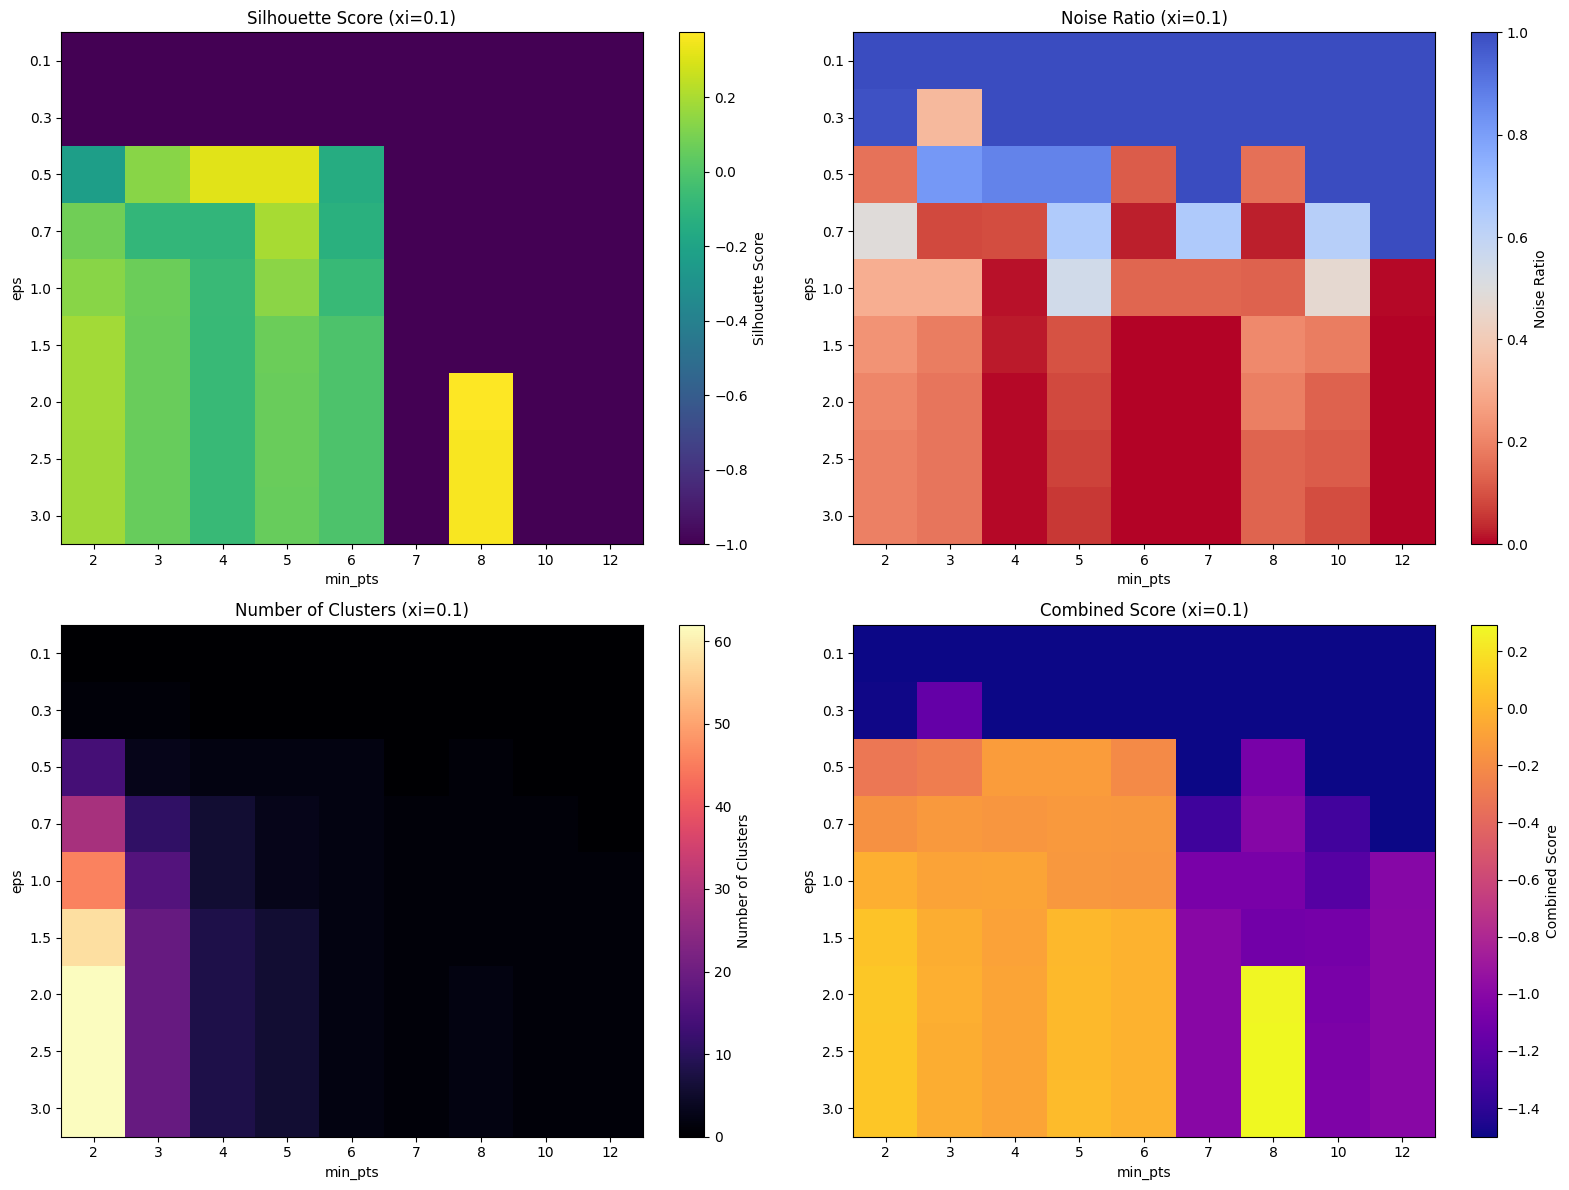

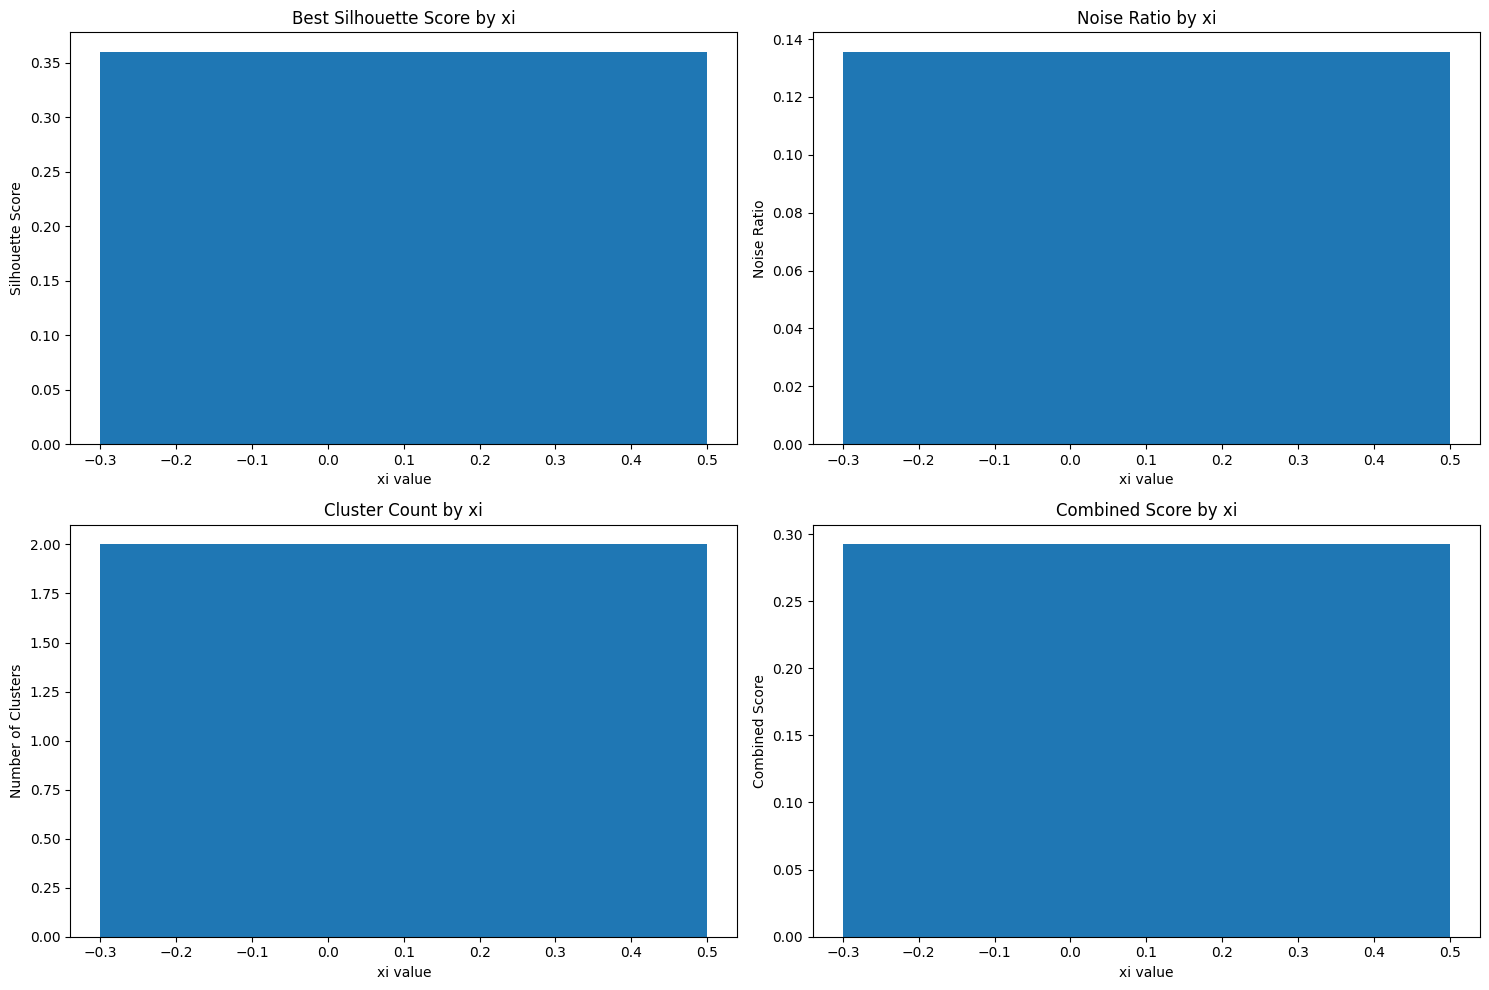

In [ ]:
# Visualize parameter optimization results
best_xi = best_overall_params['xi']
plot_parameter_heat_map(all_results, eps_range, min_pts_range, best_xi=best_xi)

* Biểu đồ so sánh giữa các giá trị xi cho thấy rằng giá trị `xi` không ảnh hưởng quá nhiều đến các chỉ số tối ưu. Điều này có thể cho thấy rằng với dữ liệu của bạn, giá trị xi trong phạm vi từ -0.3 đến 0.5 không có tác động đáng kể đến việc phân cụm.
* Biểu đồ nhiệt cho thấy rằng các tham số `eps` và `min_pts` có ảnh hưởng rõ rệt đến chất lượng phân cụm và tỷ lệ nhiễu. Cần chú ý đến các giá trị của `eps` lớn hơn, vì chúng có thể làm tăng tỷ lệ nhiễu.

In [ ]:
# Run OPTICS with optimal parameters
print("\nRunning OPTICS with optimal parameters...")
best_eps = best_overall_params['eps']
best_min_pts = best_overall_params['min_pts']
best_xi = best_overall_params['xi']

start_time = time.time()
optics = OPTICS(eps=best_eps, min_pts=best_min_pts)
optics.fit(X)
labels = optics.extract_clusters(xi=best_xi)
end_time = time.time()
execution_time = end_time - start_time

# Display results
n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"\nExecution time: {execution_time:.2f} seconds")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(labels):.2%})")


Running OPTICS with optimal parameters...

Execution time: 0.41 seconds
Number of clusters: 2
Number of noise points: 45 (13.55%)



Generating visualizations...


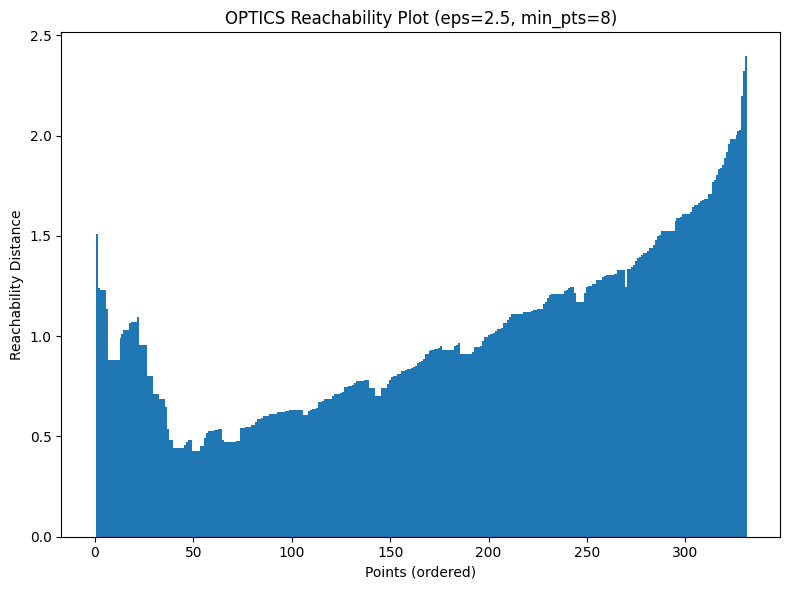

In [ ]:
# Create visualization
print("\nGenerating visualizations...")
optics.plot_reachability('optimal_reachability_plot.png')


Generating visualizations...


<ipython-input-59-0ea5671ed160>:238: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


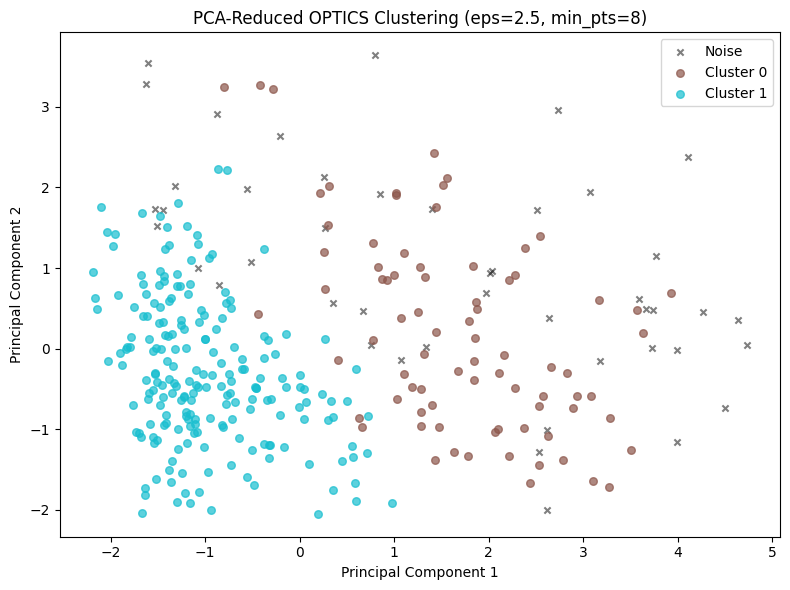

In [ ]:
# Create visualization
print("\nGenerating visualizations...")
optics.plot_clusters_with_pca(X, labels)

### Phân tích

In [ ]:
# Thêm labels vào DataFrame
df_with_labels = data.copy()
df_with_labels['Cluster'] = labels

# Tính thống kê theo từng cụm
cluster_stats = df_with_labels.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])

# In thông tin cho mỗi cụm
for cluster_id in sorted(df_with_labels['Cluster'].unique()):
    points_in_cluster = df_with_labels[df_with_labels['Cluster'] == cluster_id].drop(columns='Cluster')
    print(f"Cụm {cluster_id}:")
    print(f" - Số lượng phần tử: {len(points_in_cluster)}")
    print(f" - Tâm cụm (mean):\n{points_in_cluster.mean()}")
    print(f" - Độ lệch chuẩn (std):\n{points_in_cluster.std()}")
    print(f" - Giá trị nhỏ nhất (min):\n{points_in_cluster.min()}")
    print(f" - Giá trị lớn nhất (max):\n{points_in_cluster.max()}")
    print("\n" + "-"*50 + "\n")

Cụm -1:
 - Số lượng phần tử: 45
 - Tâm cụm (mean):
Fresh               0.532947
Milk                1.075875
Grocery             1.109749
Frozen              0.526339
Detergents_Paper    0.802024
Delicassen          0.528856
dtype: float64
 - Độ lệch chuẩn (std):
Fresh               1.453649
Milk                1.185885
Grocery             1.352730
Frozen              1.312030
Detergents_Paper    1.375099
Delicassen          1.161498
dtype: float64
 - Giá trị nhỏ nhất (min):
Fresh              -1.166987
Milk               -0.896358
Grocery            -0.871064
Frozen             -1.018021
Detergents_Paper   -0.827232
Delicassen         -1.231424
dtype: float64
 - Giá trị lớn nhất (max):
Fresh               3.373029
Milk                3.238851
Grocery             3.258853
Frozen              3.323109
Detergents_Paper    2.990711
Delicassen          3.026794
dtype: float64

--------------------------------------------------

Cụm 0:
 - Số lượng phần tử: 80
 - Tâm cụm (mean):
Fresh       

**`Phân Tích`**

**Cụm -1 (Nhiễu)** : Số lượng phần tử: 45 (~13.55%)


*   Đặc điểm chung:

    *   Mức tiêu thụ của `Fresh`(1.45), `Milk`(1.19), `Grocery`(1.35), `Frozen`(1.31), `Detergents_Paper`(1.38), và `Delicassen`(1.16) có sự phân tán rất lớn, thể hiện qua độ lệch chuẩn rất cao.
    *   Các giá trị min và max cho thấy sự dao động mạnh mẽ trong mức tiêu thụ các sản phẩm, có thể là do một số điểm có hành vi tiêu dùng rất khác biệt.

*   Hành vi:
    *   Có thể là các khách hàng với hành vi tiêu dùng rất khác biệt so với phần lớn dữ liệu, hoặc là những điểm có ít thông tin hoặc có sự thay đổi mạnh mẽ trong mức độ tiêu thụ các sản phẩm.
    *   Nhóm này không thể được phân nhóm vào bất kỳ cụm nào khác do hành vi tiêu dùng quá phân tán hoặc bất thường.


**Cụm 0**: Số lượng phần tử: 80 (~24.1%)


*   Đặc điểm chung:

    *   Mức tiêu thụ của các sản phẩm có xu hướng vừa phải, không quá cao nhưng cũng không quá thấp
    *   Độ lệch chuẩn cho các đặc trưng không quá cao, cho thấy nhóm này có hành vi tiêu dùng khá ổn định.

*   Hành vi:

    *   Nhóm này có thể là các cửa hàng nhỏ, khách hàng cá nhân, hoặc các đại lý với nhu cầu tiêu dùng cơ bản.
    *   Không ưu tiên các sản phẩm đông lạnh hay rau củ tươi sống, mà chủ yếu tiêu thụ các sản phẩm sữa, tạp hóa, và sản phẩm tẩy rửa.


**Cụm 1**: Số lượng phần tử: 207 (~62.35%)

*   Đặc điểm chung:

    *   Độ lệch chuẩn thấp cho tất cả các đặc trưng, cho thấy nhóm này có hành vi tiêu dùng ổn định hơn nhiều so với Cụm 0.
    *   Nhóm này tiêu thụ các sản phẩm như `Milk`, `Grocery`, `Frozen`, `Delicassen` ở mức thấp, cho thấy nhu cầu tiêu thụ các sản phẩm tiêu dùng cơ bản và thực phẩm chế biến sẵn thấp hơn các nhóm khác.

*   Hành vi:

    *   Nhóm này có thể đại diện cho các doanh nghiệp lớn như siêu thị, nhà hàng, hoặc chuỗi bán lẻ.
    *   Không ưu tiên sản phẩm đông lạnh và thực phẩm tươi sống, nhưng lại tiêu thụ nhiều sản phẩm tiêu dùng cơ bản và sản phẩm chế biến sẵn. Có thể là các khách hàng cần các mặt hàng tiêu dùng ổn định và có xu hướng ít thay đổi trong hành vi tiêu dùng.









